In [1]:
!pip install keras

In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D,Conv2DTranspose,Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [3]:
def conv_block(x, n_base, batch_normalization):
    
    x = Conv2D(filters=n_base, kernel_size=(3,3), 
                        strides=(1,1),padding='same')(x)
    if (batch_normalization):
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=n_base, kernel_size=(3,3), 
                        strides=(1,1),padding='same')(x)
    if (batch_normalization):
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [4]:
def downsample_block(x, n_base, batch_normalization, dropout):
    f = conv_block(x, n_base, batch_normalization)
    p = layers.MaxPool2D(pool_size = (2,2))(f)
    if(dropout):
        p = layers.Dropout(0.2)(p)
        
    return f, p

In [5]:
def upsample_block(x, f, n_base, batch_normalization, dropout):
    
    x = Conv2DTranspose(filters=n_base, kernel_size=(2,2), 
                         strides=(2,2),padding='same')(x)
    x = Concatenate()([x,f])
    if(dropout):
        x = layers.Dropout(0.2)(x)
    x = conv_block(x, n_base, batch_normalization)
        
    return x

In [6]:
def get_unet(img_w, img_h, img_ch, n_base, LR, batch_normalization, dropout):

    
    
    ## Encoder part
#     model = Sequential()
    inputs = layers.Input((img_w, img_h, img_ch))
    
    f1, p1 = downsample_block(inputs, n_base, batch_normalization, dropout)
    f2, p2 = downsample_block(p1, n_base*2, batch_normalization, dropout)
    f3, p3 = downsample_block(p2, n_base*4, batch_normalization, dropout)
    f4, p4 = downsample_block(p3, n_base*8, batch_normalization, dropout)
    
    
    ## Bottleneck
    bottleneck = conv_block(p4, n_base*16, batch_normalization)
    
    ## Decoder part
    p5 = upsample_block(bottleneck, f4, n_base*8, batch_normalization, dropout)
    p6 = upsample_block(p5, f3, n_base*4, batch_normalization, dropout)
    p7 = upsample_block(p6, f2, n_base*2, batch_normalization, dropout)
    p8 = upsample_block(p7, f1, n_base, batch_normalization, dropout)

    
    ## 1 Convo layer
    p9 = Conv2D(filters=1, kernel_size=(1,1), 
                            padding='same')(p8)
    outputs = Activation('sigmoid')(p9)
    

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    
    return model


In [9]:
!pip install scikit-image

In [7]:
## Task1a) Lung segmentation in chest X-ray images:
import os
from random import shuffle
from skimage.io import imread
from skimage.transform import resize


image_path = '/DL_course_data/Lab3/CT/Image' 
mask_path = '/DL_course_data/Lab3/CT/Mask'



In [35]:
import os
msk = imread(os.path.join(mask_path,'Im140_98_Mask.png'), as_gray=True)
msk[np.where(msk==251)]=(255)
msk[np.where(msk==156)]=(255)
msk = resize(msk, (256, 256), anti_aliasing=True).astype('float32')
msk

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

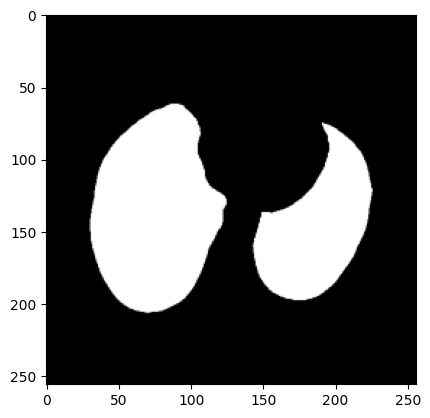

1.0

In [39]:
plt.imshow(msk, cmap='gray')
plt.show()
msk[150][100]
msk[150][200]


In [53]:
def load_data(image_path,mask_path):
    
    image_list = os.listdir(image_path)
    mask_list = os.listdir(mask_path)
    
    images = []
    masks = []


    for image in image_list:
        img = imread(os.path.join(image_path, image), as_gray=True)  # "as_grey"
        img = resize(img, (128, 128), anti_aliasing=True).astype('float32')
        images.append(img)

    for mask in mask_list:
        mask_img = imread(os.path.join(mask_path, mask), as_gray=True)
        msk[np.where(msk==251)]=(255)
        msk[np.where(msk==156)]=(255)
        mask = resize(mask_img, (128, 128), anti_aliasing=True).astype('float32')
        masks.append(mask)
        
    ## Load data in traditional way
    img_train, img_val, mask_train, mask_val = train_test_split(images, masks, shuffle = True,
                                                      test_size = 0.2)
    img_train = np.expand_dims(img_train, axis = -1)
    img_train = np.array(img_train)
    img_val = np.expand_dims(img_val, axis = -1)    
    img_val = np.array(img_val)
    mask_train = np.expand_dims(mask_train, axis = -1)
    mask_train = np.array(mask_train)
    mask_val = np.expand_dims(mask_val, axis = -1)
    mask_val = np.array(mask_val)
    
    return img_train, img_val, mask_train, mask_val
    

In [41]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [54]:
n_base =8
LR = 1e-4
batch_normalization = True
dropout = True
epochs = 50
Metric= 'Dice Coefficient'
batch_size = 8

img_w, img_h = 512,512
img_ch = 1

model = get_unet(img_w, img_h, img_ch, n_base, LR, 
                 batch_normalization, dropout)

# run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)

## BCE
# model.compile(loss = 'binary_crossentropy',          # Model Compiling   
#               optimizer = Adam(lr = LR),
#               metrics = [dice_coef])
## Dice
model.compile(loss = [dice_coef_loss],          # Model Compiling   
              optimizer = Adam(lr = LR),
              metrics = [dice_coef])



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 512, 512, 8)  80          ['input_3[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 512, 512, 8)  32         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [55]:
img_train, img_val, mask_train, mask_val = load_data(image_path,mask_path)


In [52]:
## Task 2a

model_history = model.fit(img_train,mask_train,
                            validation_data=(img_val,mask_val),
                            epochs = epochs, batch_size = batch_size,
                            verbose=1)


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [49]:
## Task 2b) Add data augmentation

image_aug = ImageDataGenerator(rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range = 0.2,
                                horizontal_flip=True)

train_generator = image_aug.flow(
                                img_train,mask_train,
                                batch_size = 8)

val_generator = image_aug.flow(
                                img_val,mask_val,
                                batch_size = 8)

model.compile(loss = [dice_coef_loss],          # Model Compiling   
              optimizer = Adam(lr = LR),
              metrics = [dice_coef, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 8)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [50]:
model_history = model.fit_generator(train_generator, steps_per_epoch = train_generator.n//batch_size,
    validation_data = val_generator, validation_steps = val_generator.n//batch_size,
    epochs = epochs,  verbose=1)

Epoch 1/50


<ipython-input-50-df9e090d64c6>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator, steps_per_epoch = train_generator.n//batch_size,


ResourceExhaustedError: Graph execution error:

Detected at node 'dice_coef_loss/Sum_1' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 972, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 505, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 540, in execute_request
      self.do_execute(
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-50-df9e090d64c6>", line 1, in <cell line: 1>
      model_history = model.fit_generator(train_generator, steps_per_epoch = train_generator.n//batch_size,
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2260, in fit_generator
      return self.fit(
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "<ipython-input-41-9af8bf88f002>", line 9, in dice_coef_loss
      return 1 - dice_coef(y_true, y_pred)
    File "<ipython-input-41-9af8bf88f002>", line 6, in dice_coef
      return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)
    File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 2544, in sum
      return tf.reduce_sum(x, axis, keepdims)
Node: 'dice_coef_loss/Sum_1'
Detected at node 'dice_coef_loss/Sum_1' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 972, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 505, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 540, in execute_request
      self.do_execute(
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-50-df9e090d64c6>", line 1, in <cell line: 1>
      model_history = model.fit_generator(train_generator, steps_per_epoch = train_generator.n//batch_size,
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2260, in fit_generator
      return self.fit(
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "<ipython-input-41-9af8bf88f002>", line 9, in dice_coef_loss
      return 1 - dice_coef(y_true, y_pred)
    File "<ipython-input-41-9af8bf88f002>", line 6, in dice_coef
      return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)
    File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 2544, in sum
      return tf.reduce_sum(x, axis, keepdims)
Node: 'dice_coef_loss/Sum_1'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dice_coef_loss/Sum_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[assert_less_equal_1/Assert/AssertGuard/pivot_f/_33/_77]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dice_coef_loss/Sum_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_15276]

In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(model_history.history["loss"], label="loss")
plt.plot(model_history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_history.history["val_loss"]),
         np.min(model_history.history["val_loss"]),
         marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend()
plt.show()

plt.figure(figsize=(4, 4))
plt.title("Dice Coefficients")
plt.plot(model_history.history['dice_coef'], label="dice")
plt.plot(model_history.history['val_dice_coef'], label="val_dice")
plt.plot( np.argmax(model_history.history["val_dice_coef"]),
         np.max(model_history.history["val_dice_coef"]),
         marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("Dice Coef")
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(4, 4))
plt.title("Precision")
plt.plot(model_history.history['precision'], label="precision")
plt.plot(model_history.history['val_precision'], label="val_precision")
plt.plot( np.argmax(model_history.history["val_precision"]),
         np.max(model_history.history["val_precision"]),
         marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("precision")
plt.legend()
plt.show()

plt.figure(figsize=(4, 4))
plt.title("Recall")
plt.plot(model_history.history['recall'], label="recall")
plt.plot(model_history.history['val_recall'], label="val_recall")
plt.plot( np.argmax(model_history.history["val_recall"]),
         np.max(model_history.history["val_recall"]),
         marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("recall")
plt.legend()
plt.show()

In [ ]:
def shuffle_list(*ls):
  l =list(zip(*ls))
  shuffle(l)
  return zip(*l)

In [ ]:
## Try out with flow from dataframe

images_list = [os.path.join(image_path,i) for i in image_list]
masks_list = [os.path.join(mask_path,i) for i in mask_list]
data = pd.DataFrame()
data['images'] = images_list
data['masks'] = masks_list


## Generator
datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)
    
img_train_generator = datagen.flow_from_dataframe(
    data,
    x_col = 'images',
    y_col = 'masks',
    color_mode = 'grayscale',
    target_size=(256,256),
    class_model = None,
    batch_size = batch_size,
    subset = 'training',
    seed = 1)

img_val_generator = datagen.flow_from_dataframe(
    data,
    x_col = 'images',
    y_col = 'masks',
    color_mode = 'grayscale',
    target_size=(256,256),
    class_model = None,
    batch_size = batch_size,
    subset = 'validation',
    seed = 1)

mask_train_generator = datagen.flow_from_dataframe(
    data,
    x_col = 'masks',
    y_col = 'images',
    color_mode = 'grayscale',
    target_size=(256,256),
    class_model = None,
    batch_size = batch_size,
    subset = 'training',
    seed = 1) 

mask_val_generator = datagen.flow_from_dataframe(
    data,
    x_col = 'masks',
    y_col = 'images',
    color_mode = 'grayscale',
    target_size=(256,256),
    class_model = None,
    batch_size = batch_size,
    subset = 'validation',
    seed = 1) 

img_train_generator, mask_train_generator = shuffle_list(img_train_generator, mask_train_generator)
img_val_generator, mask_val_generator = shuffle_list(img_val_generator, mask_val_generator)

train_generator = zip(img_train_generator, mask_train_generator)
val_generator = zip(img_val_generator, mask_val_generator)

train_steps = img_train_generator.n//img_train_generator.batch_size
val_steps = img_val_generator.n//img_val_generator.batch_size

model_histogram = model.fit_generator(train_generator, 
    steps_per_epoch = train_steps,
    validation_data = val_generator, validation_steps = val_steps,
    epochs = epochs, verbose=1)

In [242]:
## Try out with flow from dataframe

images_list = [os.path.join(image_path,i) for i in image_list]
masks_list = [os.path.join(mask_path,i) for i in mask_list]
data = pd.DataFrame()
data['images'] = images_list
data['masks'] = masks_list

df = pd.DataFrame()
df['images'] = images
df['masks'] = masks


## Generator
datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)
    
train_generator = datagen.flow_from_dataframe(
    data,
    x_col = 'images',
    y_col = 'masks',
    color_mode = 'grayscale',
    target_size=(256,256),
    class_model = 'raw',
    batch_size = batch_size,
    subset = 'training',
    shuffle = True)

val_generator = datagen.flow_from_dataframe(
    data,
    x_col = 'images',
    y_col = 'masks',
    color_mode = 'grayscale',
    target_size=(256,256),
    class_model = 'raw',
    batch_size = batch_size,
    subset = 'validation',
    shuffle = True) 


train_steps = train_generator.n//train_generator.batch_size
val_steps = val_generator.n//val_generator.batch_size

model_histogram = model.fit_generator(train_generator, 
    steps_per_epoch = train_steps,
    validation_data = val_generator,validation_steps = val_steps,
    epochs = epochs, verbose=1)

Found 188 validated image filenames belonging to 234 classes.
Found 46 validated image filenames belonging to 234 classes.


In [318]:
## Try to loaddata by  flow from dataframe
seed = 1

image_datagen = ImageDataGenerator(rescale=1/255.)
mask_datagen = ImageDataGenerator(rescale=1/255.)


image_datagen.fit(np.array(images_).reshape(234, 1024, 1024,1), augment=True, seed=seed)
mask_datagen.fit(np.array(masks_).reshape(234, 1024, 1024,1), augment=True, seed=seed)

im_path = '/DL_course_data/Lab3/X_ray'
msk_path = '/DL_course_data/Lab3/X_ray/Mask'

image_generator = image_datagen.flow_from_directory(
            im_path,
            class_mode='input',
            color_mode = 'grayscale',
            target_size=(256,256),
            seed=seed)

mask_generator = mask_datagen.flow_from_directory(
            msk_path,
            class_mode='input',
            color_mode = 'grayscale',
            target_size=(256,256),
            seed=seed)

train_generator = zip(image_generator, mask_generator)

# model_histogram = model.fit(
#             train_generator,
#             steps_per_epoch=10,
#             epochs=50)

Found 468 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [ ]:
## Try to loaddata by flow from dirctory

image_datagen = ImageDataGenerator(rescale=1/255., validation_split = 0.2)
mask_datagen = ImageDataGenerator(rescale=1/255.,validation_split = 0.2)

path = '/DL_course_data/Lab3/X_ray'
im_path = '/DL_course_data/Lab3/X_ray/Image'
msk_path = '/DL_course_data/Lab3/X_ray/Mask'

image_generator_train = image_datagen.flow_from_directory(
            path,
            class_mode=None,
            color_mode = 'grayscale',
            target_size=(256,256),
            subset = 'training')

image_generator_val = image_datagen.flow_from_directory(
            path,
            class_mode=None,
            color_mode = 'grayscale',
            target_size=(256,256),
            subset = 'validation')


mask_generator_train = mask_datagen.flow_from_directory(
            msk_path,
            class_mode='input',
            color_mode = 'grayscale',
            target_size=(256,256),
            subset = 'training')


mask_generator_val = mask_datagen.flow_from_directory(
            msk_path,
            class_mode='input',
            color_mode = 'grayscale',
            target_size=(256,256),
            subset = 'validation')

train_generator = zip(image_generator_train, mask_generator_train)
val_generator = zip(image_generator_val, mask_generator_val)


model_histogram = model.fit_generator(train_generator, steps_per_epoch = image_generator_train.n//batch_size,
    validation_data = val_generator, validation_steps = image_generator_val.n//batch_size,
    epochs = epochs,  verbose=1)

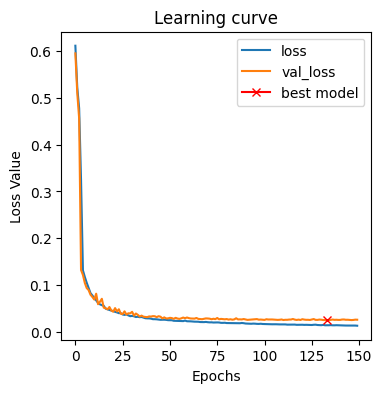

In [336]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(model_histogram.history["loss"], label="loss")
plt.plot(model_histogram.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_histogram.history["val_loss"]),
         np.min(model_histogram.history["val_loss"]),
         marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend()
plt.show()


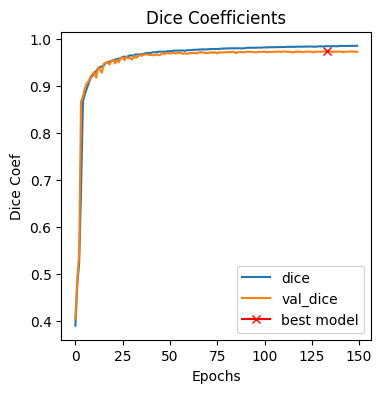

In [337]:
plt.figure(figsize=(4, 4))
plt.title("Dice Coefficients")
plt.plot(model_histogram.history['dice_coef'], label="dice")
plt.plot(model_histogram.history['val_dice_coef'], label="val_dice")
plt.plot( np.argmax(model_histogram.history["val_dice_coef"]),
         np.max(model_histogram.history["val_dice_coef"]),
         marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("Dice Coef")
plt.legend()
plt.show()